# Introduction

This program performs analysis and visualization of openLCA results from an LCIA calculation, starting with an excel file export. This program assumes that you've already compiled an excel file of the unit processes exported from your openLCA database, with ISIC categories assigned to each process. This excel file should be named "database_process_summary_added.xlsx" with the corresponding file path.

# Setup

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import xlsxwriter
import re

In [38]:
# Set up and define variables
# Change these variables to match your data

impact_category_name = "climate change - global warming potential (GWP100) (Nitrous Oxide, Methane, Carbon Dioxide)"
product_system_name = "GeoH2 (85% mol H2; H2 Average Fugitive; CH4 Capture)"
product_system_name_simplified = "GeoH2_85molH2_H2_AverageFugitive_CH4Capture" # Simplified name file naming; Must not contain spaces or special characters
GHG_intensity_impact_threshold = 0.05 # kg CO2 eq / kg H2 # Flows or processes with an impact lower than this threshold will be grouped into the "Other" category in the impact contribution plot.

# LCA results file path and sheet names
lca_results_file_path = r'C:\Users\laura\OneDrive\Documents\UT_graduate\WEG_graduate_research\Hydrogen_fugitive_emissions_natural_h2\openLCA_ecoinvent\Hydrogen_gas__at_processing__production_mixture__to_consumer__kg___US__85__mol_H2____H2_Average___CH4_Capture.xlsx'
direct_impact_sheet_name = 'Direct impact contributions' #sheet name in the LCA results file
impact_by_flow_sheet_name = 'Impact contributions by flow' #sheet name in the LCA results file

# Database process summary file path; File must be named "database_process_summary_added.xlsx"
database_process_summary_file_path = r'C:\Users\laura\OneDrive\Documents\UT_graduate\WEG_graduate_research\Hydrogen_fugitive_emissions_natural_h2\openLCA_ecoinvent\openLCA\database_process_summary_added.xlsx'

# Define the output Excel file path
output_excel_file_path = r'C:\Users\laura\OneDrive\Documents\UT_graduate\WEG_graduate_research\Hydrogen_fugitive_emissions_natural_h2\openLCA_ecoinvent' + f'\\{product_system_name_simplified}_data_export.xlsx'

In [39]:
# Check if the "output_excel_file_path" contains special characters or spaces
if re.search(r'[^\w\\:.-]', output_excel_file_path):
    print("The output Excel file path contains special characters or spaces.")
    print("Please update the 'product_system_name_simplified' variable to remove special characters or spaces.")
else:
    print("The output Excel file path is valid.")

The output Excel file path is valid.


# Read in LCA Results Excel File
Read in LCA results impact by unit process and by flow

In [40]:
# Read the specified worksheet into a DataFrame
df_process_impact = pd.read_excel(lca_results_file_path, sheet_name=direct_impact_sheet_name)
df_flows_impact = pd.read_excel(lca_results_file_path, sheet_name=impact_by_flow_sheet_name)

In [41]:
# Drop the first column if it contains only empty values
if df_process_impact.iloc[:, 0].isnull().all():
    df_process_impact.drop(df_process_impact.columns[0], axis=1, inplace=True)
if df_flows_impact.iloc[:, 0].isnull().all():
    df_flows_impact.drop(df_flows_impact.columns[0], axis=1, inplace=True)

# Transpose the DataFrame
df_process_impact_transposed = df_process_impact.transpose()
df_flows_impact_transposed = df_flows_impact.transpose()

# Reset the index of the transposed DataFrame
df_process_impact_transposed.reset_index(drop=True, inplace=True)
df_flows_impact_transposed.reset_index(drop=True, inplace=True)

In [42]:
# Find the column index of the target impact category in the transposed DataFrames
process_column_index = df_process_impact_transposed.columns[df_process_impact_transposed.iloc[1] == impact_category_name].tolist()
flows_column_index = df_flows_impact_transposed.columns[df_flows_impact_transposed.iloc[1] == impact_category_name].tolist()

# If the column is found, retrieve its index; otherwise, return None
process_column_index = process_column_index[0] if process_column_index else None
flows_column_index = flows_column_index[0] if flows_column_index else None
print(f"Process column index: {process_column_index}")
print(f"Flows column index: {flows_column_index}")

# Create a copy of transposed DataFrames with only specified columns
process_columns_to_keep = [0, 1, 2, process_column_index]
flows_columns_to_keep = [0, 1, 2, 3, 4, flows_column_index]
df_process_impact_filtered = df_process_impact_transposed.iloc[:, process_columns_to_keep]
df_flows_impact_filtered = df_flows_impact_transposed.iloc[:, flows_columns_to_keep]

impact_category_uuid = df_process_impact_filtered.iloc[0, 3]
impact_category_reference_unit = df_process_impact_filtered.iloc[2, 3]
print(f"Impact category UUID: {impact_category_uuid}")
print(f"Impact category reference unit: {impact_category_reference_unit}")

# Remove unnecessary rows and rename the columns of the filtered DataFrames
df_process_impact_filtered = df_process_impact_filtered.iloc[4:].reset_index(drop=True)
df_process_impact_filtered.columns = ['Process_UUID', 'Process', 'Location', 'GWP100_Impact_Value_kg_CO2eq']
df_flows_impact_filtered = df_flows_impact_filtered.iloc[4:].reset_index(drop=True)
df_flows_impact_filtered.columns = ['Flow_UUID', 'Flow', 'Flow_Category', 'Flow_Sub-category', 'Flow_Unit', 'GWP100_Impact_Value_kg_CO2eq']


Process column index: 7
Flows column index: 9
Impact category UUID: f1701a93-f252-4082-92f8-390ad9fd9bae
Impact category reference unit: kg CO2-Eq


# Read in OpenLCA Database Process Summary Excel File with ISIC Classifications
Read in unique list of unit processes in openLCA database

In [43]:
# Read in the database process summary file
database_process_df = pd.read_excel(database_process_summary_file_path)

In [44]:
# Split column "ISIC_Category" into multiple columns using "/" as the delimiter
split_columns = database_process_df['ISIC_Category'].str.split('/', expand=True)

# Rename the new columns for clarity
split_columns.columns = ['ISIC_Category_Section', 'ISIC_Category_Division', 'ISIC_Category_Group', 'ISIC_Category_Class']

# Add the split columns as additional columns to database_process_df
database_process_df = pd.concat([database_process_df, split_columns], axis=1)

# Merge Database Process Summary DataFrame to LCA results Process Impact DataFrame

In [45]:
# Merge the database process summary DataFrame with the filtered process impact DataFrame
merged_process_df = pd.merge(df_process_impact_filtered, database_process_df, on='Process_UUID', how='left')

# Check if the "Process" column exists in both DataFrames after the merge
if 'Process_x' in merged_process_df.columns and 'Process_y' in merged_process_df.columns:
    # Check if the "Process" columns match in both DataFrames
    if (merged_process_df['Process_x'] == merged_process_df['Process_y']).all():
        # Drop one of the "Process" columns and rename the other to "Process"
        merged_process_df.drop(columns=['Process_y'], inplace=True)
        merged_process_df.rename(columns={'Process_x': 'Process'}, inplace=True)
    else:
        print("Warning: Process columns do not match completely.")
else:
    print("Error: Process columns are missing in the merged DataFrame.")

Error: Process columns are missing in the merged DataFrame.


# Analyze DataFrames

In [51]:
# Convert the GWP100 impact value to numeric, forcing errors to NaN
merged_process_df['GWP100_Impact_Value_kg_CO2eq'] = pd.to_numeric(merged_process_df['GWP100_Impact_Value_kg_CO2eq'], errors='coerce')
df_process_impact_filtered['GWP100_Impact_Value_kg_CO2eq'] = pd.to_numeric(df_process_impact_filtered['GWP100_Impact_Value_kg_CO2eq'], errors='coerce')

# Drop rows with NaN values in the GWP100 impact value column
merged_process_df.dropna(subset=['GWP100_Impact_Value_kg_CO2eq'], inplace=True)
df_flows_impact_filtered.dropna(subset=['GWP100_Impact_Value_kg_CO2eq'], inplace=True)

In [52]:
# Group the data by "Process" and sum the GWP100 impact values, then sort
grouped_process_df = merged_process_df.groupby('Process')['GWP100_Impact_Value_kg_CO2eq'].sum().reset_index()
grouped_process_df.sort_values(by='GWP100_Impact_Value_kg_CO2eq', ascending=False, inplace=True)

# Group the data by "ISIC_Category_Section" and sum the GWP100 impact values, then sort
grouped_isic_df = merged_process_df.groupby('ISIC_Category_Section')['GWP100_Impact_Value_kg_CO2eq'].sum().reset_index()
grouped_isic_df.sort_values(by='GWP100_Impact_Value_kg_CO2eq', ascending=False, inplace=True)

# Group the data by "Flow" and sum the GWP100 impact values, then sort
grouped_flows_df = df_flows_impact_filtered.groupby('Flow')['GWP100_Impact_Value_kg_CO2eq'].sum().reset_index()
grouped_flows_df.sort_values(by='GWP100_Impact_Value_kg_CO2eq', ascending=False, inplace=True)

In [60]:
# Create copies of the grouped DataFrames for "Process", "ISIC_Category_Section", and "Flows" to group the "Other" category separately
grouped_process_other_df = grouped_process_df.copy()
grouped_isic_other_df = grouped_isic_df.copy()
grouped_flows_other_df = grouped_flows_df.copy()

# Group "Process" with less than the "GHG_Intensity_Impact_Threshold" value into "Other" category
grouped_process_other_df['Process'] = grouped_process_other_df['Process'].where(
    grouped_process_other_df['GWP100_Impact_Value_kg_CO2eq'] >= GHG_intensity_impact_threshold, 'Other'
)

# Aggregate the "Other" group and sum the GWP100 impact values
grouped_process_other_df = grouped_process_other_df.groupby('Process', as_index=False).sum().reset_index(drop=True)

# Group "ISIC_Category_Sections" with less than the "GHG_Intensity_Impact_Threshold" value into "Other" category
grouped_isic_other_df['ISIC_Category_Section'] = grouped_isic_other_df['ISIC_Category_Section'].where(
    grouped_isic_other_df['GWP100_Impact_Value_kg_CO2eq'] >= GHG_intensity_impact_threshold, 'Other'
)

# Aggregate the "Other" group and sum the GWP100 impact values
grouped_isic_other_df = grouped_isic_other_df.groupby('ISIC_Category_Section', as_index=False).sum().reset_index(drop=True)

# Group "Flows" with less than the "GHG_Intensity_Impact_Threshold" value into "Other" category
grouped_flows_other_df['Flow'] = grouped_flows_other_df['Flow'].where(
    grouped_flows_other_df['GWP100_Impact_Value_kg_CO2eq'].astype(float) >= GHG_intensity_impact_threshold, 'Other'
)

# Aggregate the "Other" group and sum the GWP100 impact values
grouped_flows_other_df = grouped_flows_other_df.groupby('Flow', as_index=False).sum().reset_index(drop=True)

In [61]:
# Write the grouped DataFrames to separate sheets in the Excel file
with pd.ExcelWriter(output_excel_file_path, engine='xlsxwriter') as writer:
    grouped_process_df.to_excel(writer, sheet_name='Grouped_Process', index=False)
    grouped_process_other_df.to_excel(writer, sheet_name='Grouped_Process_Other', index=False)
    grouped_isic_df.to_excel(writer, sheet_name='Grouped_ISIC', index=False)
    grouped_isic_other_df.to_excel(writer, sheet_name='Grouped_ISIC_Other', index=False)
    grouped_flows_df.to_excel(writer, sheet_name='Grouped_Flows', index=False)
    grouped_flows_other_df.to_excel(writer, sheet_name='Grouped_Flows_Other', index=False)

print(f"Grouped data has been exported to {output_excel_file_path}")

Grouped data has been exported to C:\Users\laura\OneDrive\Documents\UT_graduate\WEG_graduate_research\Hydrogen_fugitive_emissions_natural_h2\openLCA_ecoinvent\GeoH2_85molH2_H2_AverageFugitive_CH4Capture_data_export.xlsx


# Plot Results

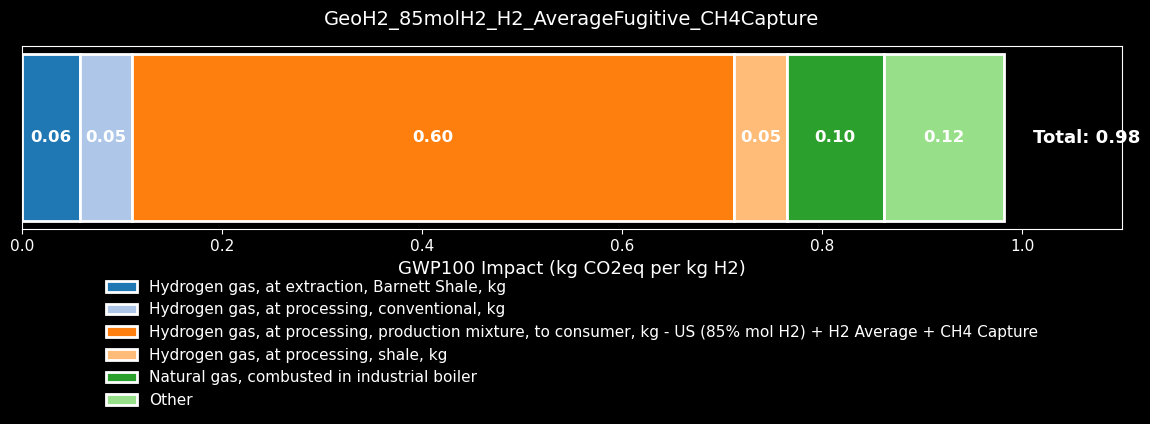

In [62]:
##### Plotting #####
# Create a horizontal bar plot

plt.figure(figsize=(12, 5))
plt.style.use('dark_background')

colors = plt.cm.tab20.colors
cumulative_width = 0
bar_height = 0.3

for i, (process, value) in enumerate(grouped_process_other_df.itertuples(index=False, name=None)):
    value = float(value)  # Convert value to float
    plt.barh(
        y=0,
        width=value,
        left=cumulative_width,
        height=bar_height,
        color=colors[i % len(colors)],
        edgecolor='white',
        linewidth=2,
        label=process
    )
    # Only show text if the segment is wide enough
    if value > 0.05:
        plt.text(
            x=cumulative_width + value / 2,
            y=0,
            s=f'{value:.2f}',
            va='center',
            ha='center',
            color='white',
            fontsize=12,
            fontweight='bold'
        )
    cumulative_width += value

# Add total at the end, with padding
plt.text(
    x=cumulative_width + 0.03 * cumulative_width,
    y=0,
    s=f'Total: {cumulative_width:.2f}',
    va='center',
    ha='left',
    color='white',
    fontsize=13,
    fontweight='bold'
)

plt.xlabel('GWP100 Impact (kg CO2eq per kg H2)', fontsize=13, color='white')
plt.title(product_system_name_simplified, fontsize=14, color='white', pad=15, wrap=True)
plt.xticks(color='white', fontsize=11)
plt.yticks([])

plt.xlim(0, cumulative_width * 1.12)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=11,
    frameon=False
)

plt.tight_layout(pad=2)
plt.show()